In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import scipy.stats as stats
from mpl_toolkits.mplot3d import Axes3D
from get_data import *

# SciKit Learn Modules
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics

# Load Standardized Industrials Data

In [2]:
industrials_df_col_names = [
	't_ev',
	't_rev',
	'ebitda',
	'ebitda_margin',
	't_ev/t_rev',
	't_ev/ebitda',
	'est_ann_rev_gr_minus_1yr_minus_capiq',
	'est_ann_ebitda_gr_minus_1yr_minus_capiq',
	't_rev_1yr_growth',
	'ebitda_1yr_growth',
	't_rev_3_yr_cagr',
	'ebitda_3yr_cagr',
	't_rev_5yr_cagr',
	'ebitda_5yr_cagr',
	'return_on_assets',
	'return_on_equity',
	'capex_as_percent_rev',
	'ebitda/interest_exp',
	't_debt/cap_percent',
	't_debt/equity_percent'
	]

# Load Raw Data
raw_data_arrays         = get_raw_data()
raw_industrials_array   = np.split(raw_data_arrays[2], [1], axis=1)
raw_industrials_array_x = raw_industrials_array[1]
raw_industrials_array_y = raw_industrials_array[0]
raw_industrials_df      = pd.DataFrame( raw_data_arrays[2], columns=industrials_df_col_names )

# Load Standardized Data
std_data_arrays         = get_standardized_data()
std_industrials_array   = np.split(std_data_arrays[2], [1], axis=1)
std_industrials_array_x = std_industrials_array[1]
std_industrials_array_y = std_industrials_array[0]
std_industrials_df      = pd.DataFrame( std_data_arrays[2], columns=industrials_df_col_names )

# Plot Correlation Matrix

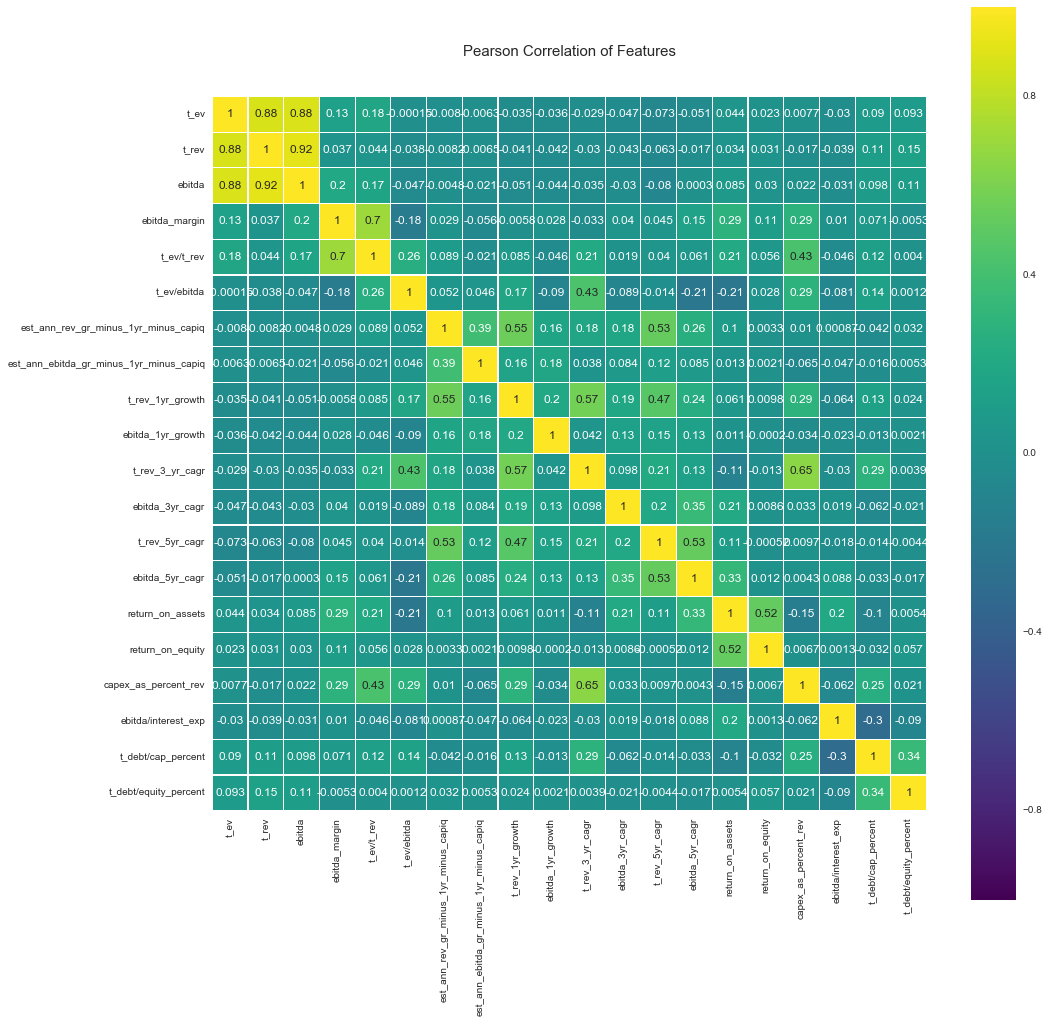

In [3]:
# Plot Feature Correlation Matrix
colormap = plt.cm.viridis
plt.figure( figsize=(16,16) )
plt.title( 'Pearson Correlation of Features', y=1.05, size=15 )
sns.heatmap( std_industrials_df.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True )

In [4]:
feature_units = [
	'Million US Dollars ($)',
	'Million US Dollars ($)',
	'Million US Dollars ($)',
	'Percentage (%)',
	'Ratio',
	'Ratio',
	'Percentage (%)',
	'Percentage (%)',
	'Percentage (%)',
	'Percentage (%)',
	'Percentage (%)',
	'Percentage (%)',
	'Percentage (%)',
	'Percentage (%)',
	'Percentage (%)',
	'Percentage (%)',
	'Percentage (%)',
	'Ratio',
	'Ratio',
	'Ratio'
	]

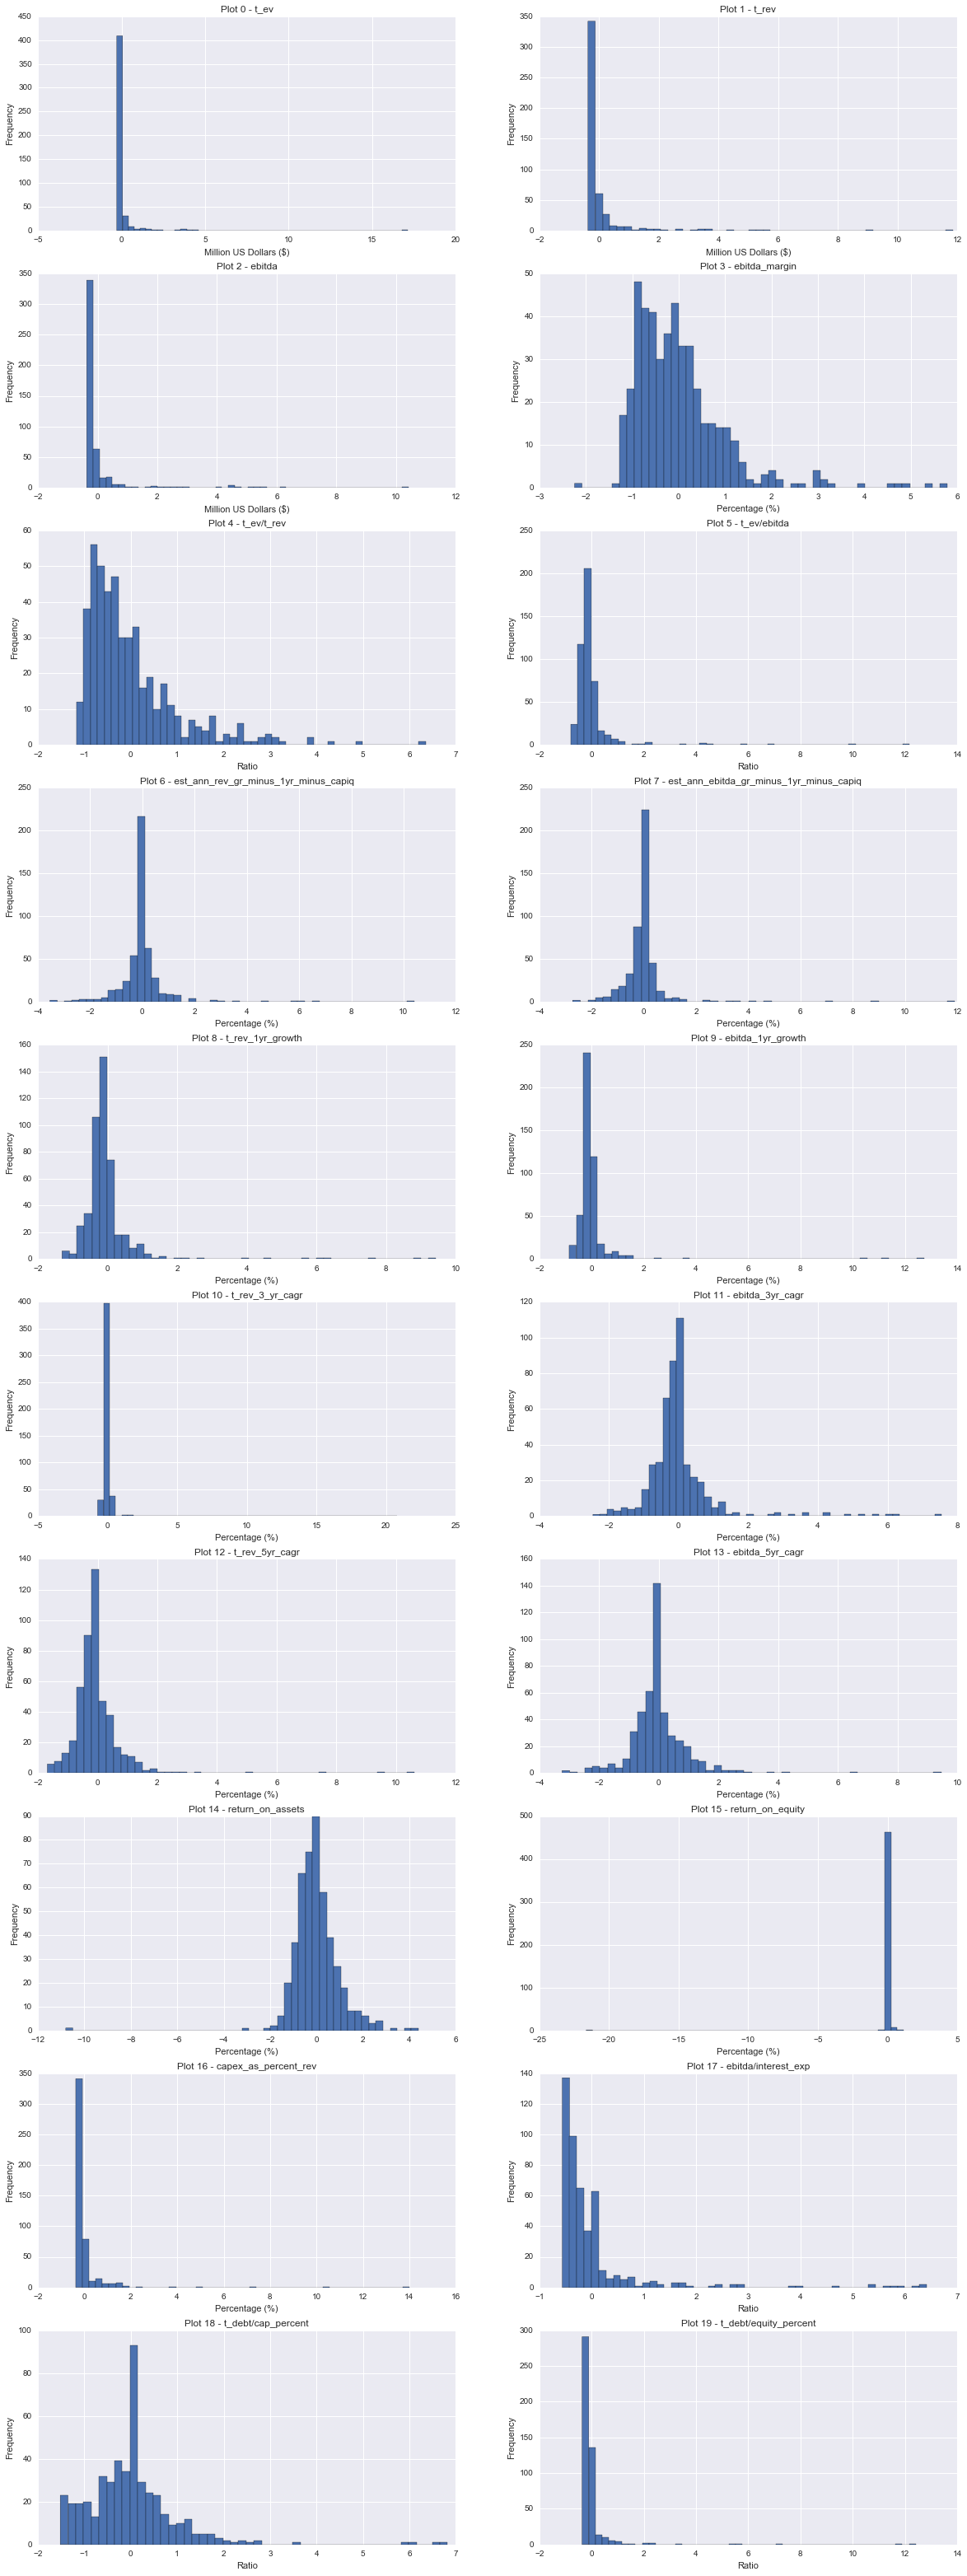

In [5]:
# Plot Standardized Feature Distributions
fig, ax = plt.subplots( 10, 2, figsize=(20, 55) )
a = ax.flatten()
for i, col in enumerate( std_industrials_df.columns ):
    std_industrials_df[col].plot( 'hist', bins=50, ax=a[i] )
    a[i].set_title( 'Plot ' + str(i) + ' - ' + col )
    a[i].set_xlabel( feature_units[i] )

It seems some features follow a normal distribution while others follow a lognormal distribution. Lets try taking the log of the features in <b>Plots 0, 1, 2, 16, 17, 18, and 19</b>, and replotting the distributions.

# Plot Standardized Log Feature Distributions

In [6]:
# Functions to Perform Log10 Operation on Specific Feature Vectors 
features_to_transform = [0, 1, 2, 16, 17, 18, 19]

def log_basis( feature_vector ):
    return np.log10( feature_vector )

def log_transform_features(feature_matrix, features_to_transform):
    transformed_features  = []
    split_features = np.split( feature_matrix, feature_matrix.shape[1], axis=1 )
    for feature_num in list(range(len( split_features ))):
        feature = split_features[ feature_num ]
        if feature_num in features_to_transform:
            feature = log_basis( feature )
        transformed_features.append( feature )
    concat_features_array = np.concatenate( transformed_features, axis=1 )
    concat_features_array = scale(mean_fill_nan_entries( concat_features_array, is_df=False ))
    return concat_features_array

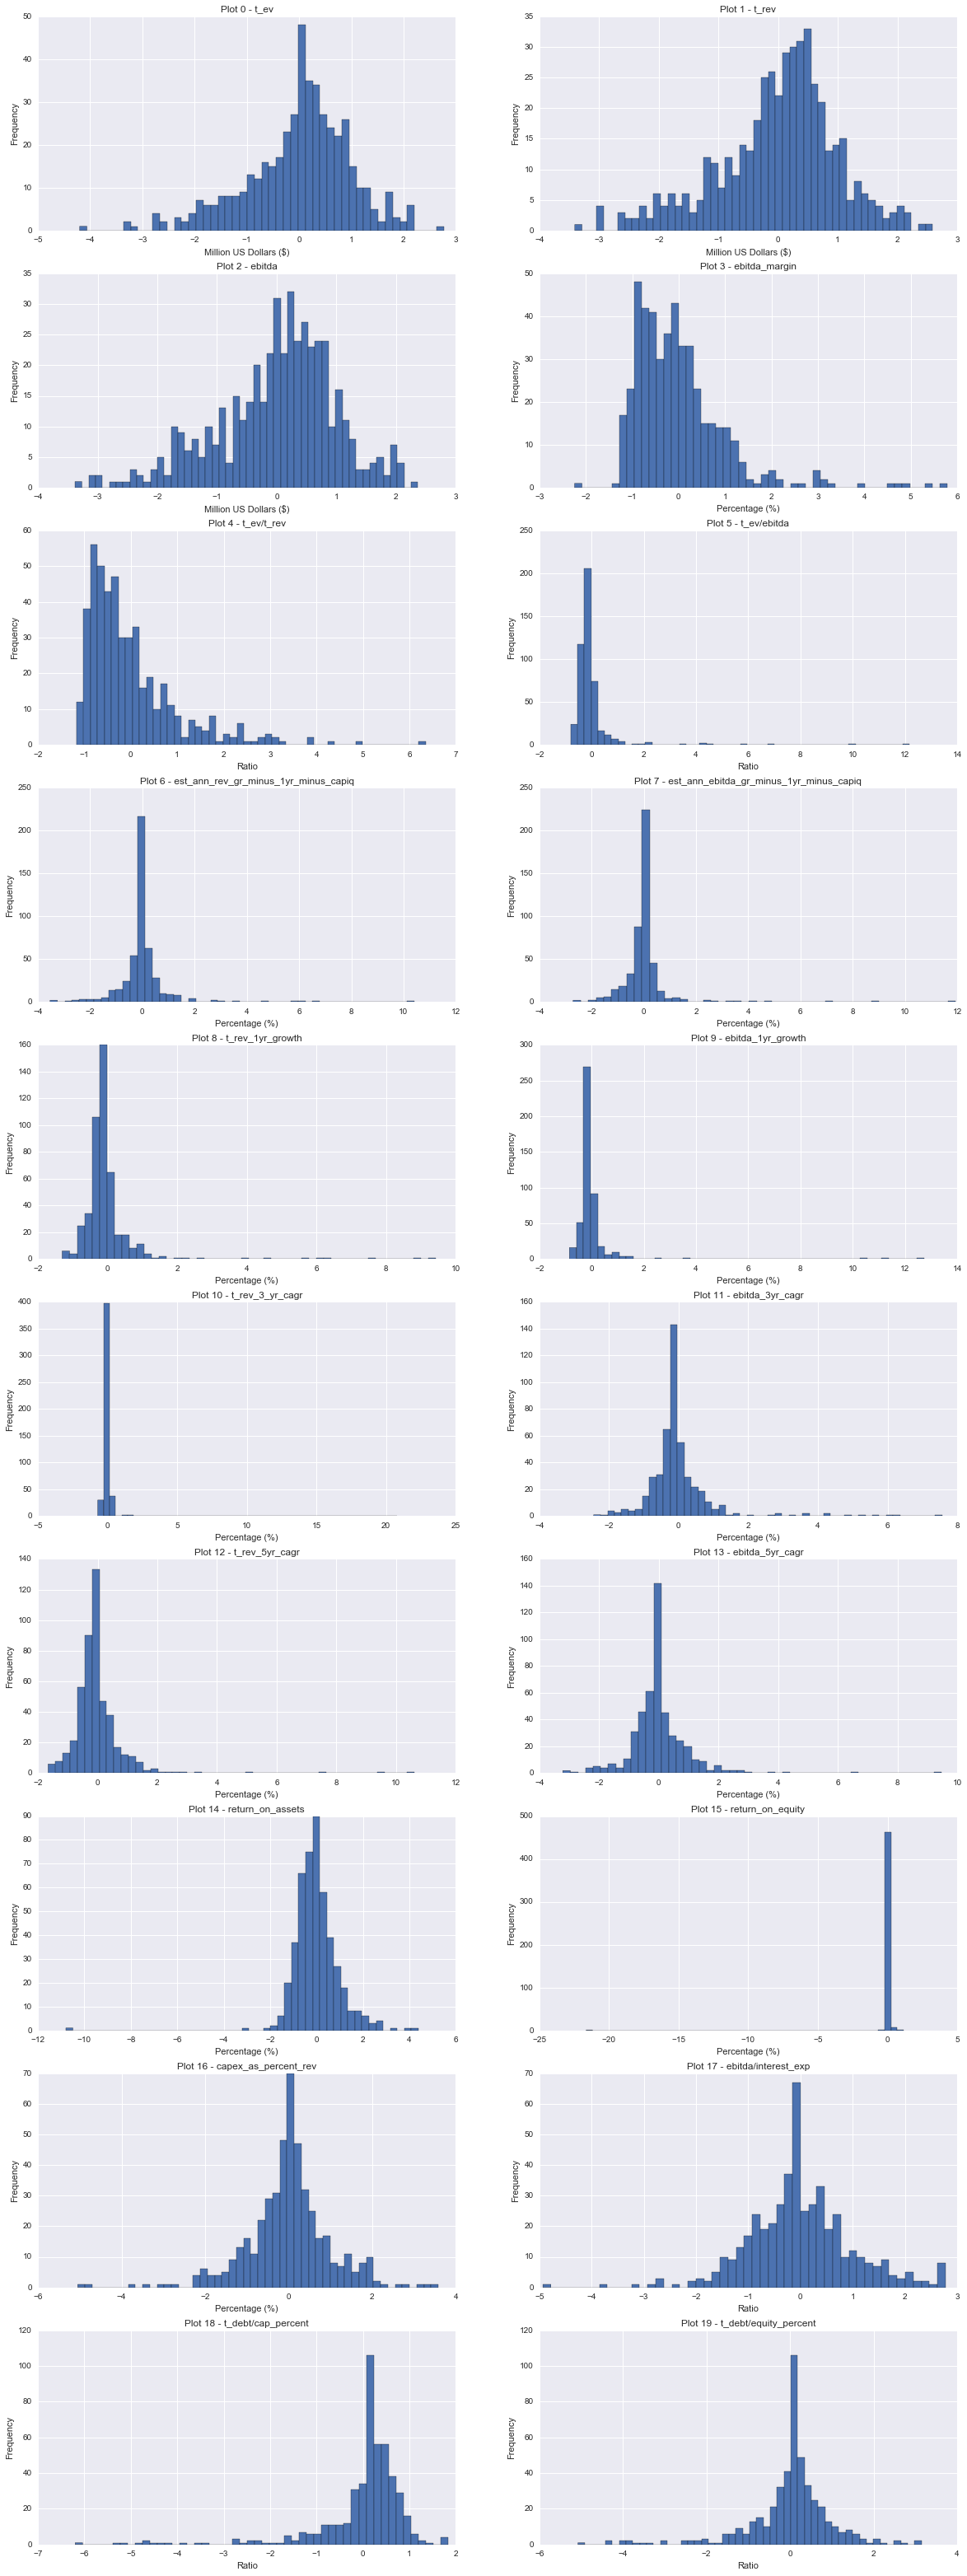

In [7]:
# Transform Raw Data Features
std_industrials_log_data = log_transform_features(raw_data_arrays[2], features_to_transform)
std_industrials_log_df   = pd.DataFrame( std_industrials_log_data, columns=industrials_df_col_names )

# Plot Raw Log Feature Distributions
fig, ax = plt.subplots( 10, 2, figsize=(20, 55) )
a = ax.flatten()
for i, col in enumerate( std_industrials_log_df.columns ):
    std_industrials_log_df[col].plot( 'hist', bins=50, ax=a[i] )
    a[i].set_title( 'Plot ' + str(i) + ' - ' + col )
    a[i].set_xlabel( feature_units[i] )

# Split Data

In [8]:
data = np.split( std_industrials_log_data, [1], axis=1 )
y_data = data[0]
x_data = data[1]

# OLS Regression

In [9]:
ols_model = LinearRegression()
scores = cross_val_score(ols_model, x_data, y_data, scoring='neg_mean_squared_error', cv=5)
# print('MSEs:', scores*-1)
print("Average MSE: %0.4f (+/- %0.4f)" % (-scores.mean(), scores.std()))

Average MSE: 0.1702 (+/- 0.0704)


# Lasso Regression 

Average MSE (alpha = 1e-2): 0.1667 (+/- 0.0876)


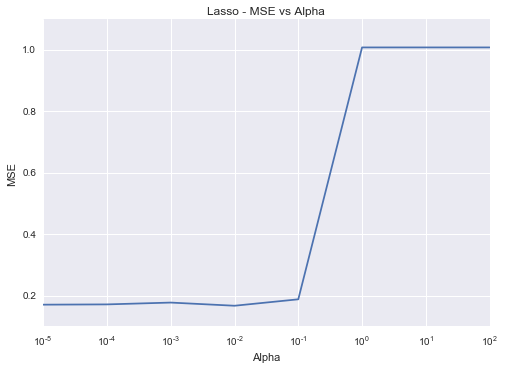

In [10]:
lasso_model = Lasso()
alphas         = [ 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100 ]
lasso_mses     = []
lasso_avg_mses = []
lasso_std_mses = []

for alpha in alphas:
    lasso_model.alpha = alpha
    scores = cross_val_score(lasso_model, x_data, y_data, scoring='neg_mean_squared_error', cv=5)
    lasso_mses.append( scores*-1 )
    lasso_avg_mses.append( -scores.mean() )
    lasso_std_mses.append( scores.std() )

# Plot Hyperparameter Selection
plt.semilogx( alphas, lasso_avg_mses )
plt.title('Lasso - MSE vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('MSE')

# print('MSEs (alpha = 1e-2):', lasso_mses[3]*-1)
print("Average MSE (alpha = 1e-2): %0.4f (+/- %0.4f)" % (lasso_avg_mses[3], lasso_std_mses[3]))

# Ridge Regression

Average MSE (alpha = 1e-2): 0.1601 (+/- 0.0685)


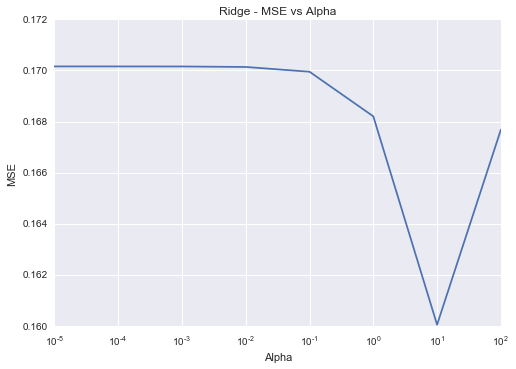

In [11]:
ridge_model = Ridge()
alphas         = [ 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100 ]
ridge_mses     = []
ridge_avg_mses = []
ridge_std_mses = []

for alpha in alphas:
    ridge_model.alpha = alpha
    scores = cross_val_score(ridge_model, x_data, y_data, scoring='neg_mean_squared_error', cv=5)
    ridge_mses.append( scores*-1 )
    ridge_avg_mses.append( -scores.mean() )
    ridge_std_mses.append( scores.std() )

# Plot Hyperparameter Selection
plt.semilogx( alphas, ridge_avg_mses )
plt.title('Ridge - MSE vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('MSE')

# print('MSEs (alpha = 1e-2):', lasso_mses[3]*-1)
print("Average MSE (alpha = 1e-2): %0.4f (+/- %0.4f)" % (ridge_avg_mses[6], ridge_std_mses[6]))

# Top 5 Features

In [38]:
ridge_model = Ridge(alpha= 10)
ridge_model.fit(x_data,y_data)
betas = ridge_model.coef_
beta_pairs = []
for i in range(len(betas[0])):
    beta_pairs.append((i,betas[0][i])) 
sorted_betas = sorted(beta_pairs, key=lambda x: x[1], reverse = True) 
for i in range(5):
    print(industrials_df_col_names[i+1])

t_rev
ebitda
ebitda_margin
t_ev/t_rev
t_ev/ebitda
